In [438]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from copy import copy


def load(path):
    return mrcfile.mmap(path, mode="r").data


def save(save_path, data):
    with mrcfile.new(save_path, overwrite=True) as mrc:
        mrc.set_data(data)


LINEWIDTH = 3
ALPHA = 1.0


def crop_roi(volume, z, origin_xy, shape_wh, orientation):
    if orientation == "xy":
        crop = volume[
            z,
            origin_xy[1] : origin_xy[1] + shape_wh[1],
            origin_xy[0] : origin_xy[0] + shape_wh[0],
        ]
    elif orientation == "xz":
        crop = volume[
            z - shape_wh[1] // 2 : z + shape_wh[1] // 2,
            origin_xy[1],
            origin_xy[0] : origin_xy[0] + shape_wh[0],
        ]
    elif orientation == "yz":
        crop = volume[
            z - shape_wh[1] // 2 : z + shape_wh[1] // 2,
            origin_xy[1] : origin_xy[1] + shape_wh[0],
            origin_xy[0],
        ]
    return crop


def draw_rect(origin, shape, color, linestyle="solid", lw=LINEWIDTH, alpha=ALPHA):
    return patches.Rectangle(
        (origin[0], origin[1]),
        shape[0],
        shape[1],
        edgecolor=color,
        facecolor="none",
        lw=lw,
        alpha=alpha,
        linestyle=linestyle,
    )


def draw_roi(origin_xy, shape_wh, color, orientation):
    if orientation == "xy":
        obj = draw_rect(origin_xy, shape_wh, color)
    elif orientation == "xz":
        obj = {
            "x": [origin_xy[0], origin_xy[0] + shape_wh[0]],
            "y": [origin_xy[1], origin_xy[1]],
            "color": color,
        }
    elif orientation == "yz":
        obj = {
            "x": [origin_xy[0], origin_xy[0]],
            "y": [origin_xy[1], origin_xy[1] + shape_wh[0]],
            "color": color,
        }
    return obj


def plot_rect(ax, obj):
    ax.add_patch(copy(obj))


def plot_obj(ax, roi):
    obj, orientation = roi["obj"], roi["orientation"]
    if orientation == "xy":
        plot_rect(ax, obj)
    else:
        ax.plot(
            obj["x"],
            obj["y"],
            color=obj["color"],
            linewidth=LINEWIDTH * 2,
            linestyle=(0, (1, 1)),
            alpha=ALPHA,
        )


def process_rois(raw, cs, z, roi_list):
    for i, roi in enumerate(roi_list):
        origin_xy, shape_wh, color, orientation = (
            roi["origin_xy"],
            roi["shape_wh"],
            roi["color"],
            roi["orientation"],
        )
        roi_list[i]["crop_raw"] = crop_roi(raw, z, origin_xy, shape_wh, orientation)
        roi_list[i]["crop_cs"] = crop_roi(cs, z, origin_xy, shape_wh, orientation)
        roi_list[i]["obj"] = draw_roi(origin_xy, shape_wh, color, orientation)
    return roi_list

In [439]:
raw_path = "/nfs/datasync4/inacio/data/raw_data/cryo/novareconstructions/rotacell_grid1_TS09_ctf_3xBin.rec"
cs_path = "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS09_ctf_3xBin/result.rec"

raw = load(raw_path)
cs = load(cs_path)

raw = np.rot90(raw, k=-1, axes=(1, 2))
cs = np.rot90(cs, k=-1, axes=(1, 2))

In [745]:
# Volume params

vmin_raw, vmax_raw = -1877, 1899
vmin_cs, vmax_cs = -464, 404
z, y, x = 533, 500, 1920 - (500 + 800)
dz, dy, dx = 220, 800, 800

# ROIs

roi_list = []

roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [580, 150],
        "shape_wh": [110, 110],
        "color": "fuchsia",
    }
)

roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [60, 250],
        "shape_wh": [160, 160],
        "color": "brown",
    }
)

# roi_list.append({
#     'orientation': 'yz',
#     'origin_xy': [140, 475],
#     'shape_wh': [160, 160],
#     'color': 'aqua',
# })

# roi_list.append({
#     'orientation': 'xz',
#     'origin_xy': [225, 230],
#     'shape_wh': [200, 200],
#     'color': 'yellow',
# })

roi_list.append(
    {
        "orientation": "xz",
        "origin_xy": [60, 355],
        "shape_wh": [160, 160],
        "color": "aqua",
    }
)

roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [130, 520],
        "shape_wh": [110, 110],
        "color": "yellow",
    }
)


roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [415, 265],
        "shape_wh": [110, 110],
        "color": "red",
    }
)

roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [580, 320],
        "shape_wh": [110, 110],
        "color": "blue",
    }
)


roi_list.append(
    {
        "orientation": "xy",
        "origin_xy": [330, 337],
        "shape_wh": [110, 110],
        "color": "lime",
    }
)

# Run

volume_raw = np.asarray(raw[z - dz // 2 : z + dz // 2, y : y + dy, x : x + dx])
volume_cs = np.asarray(cs[z - dz // 2 : z + dz // 2, y : y + dy, x : x + dx])

roi_list = process_rois(volume_raw, volume_cs, dz // 2, roi_list)

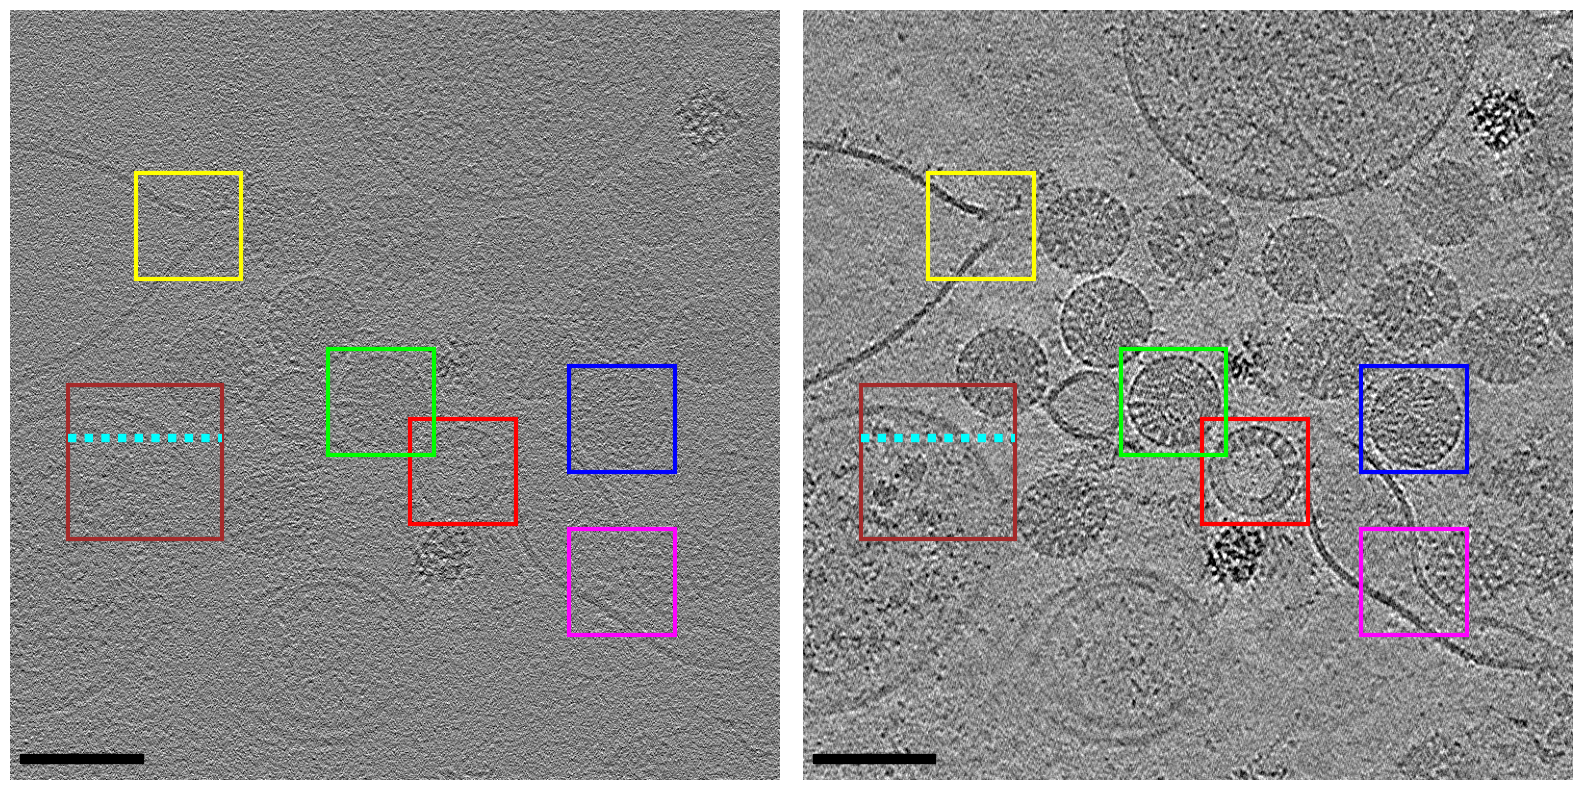

In [749]:
voxel_size = 2.62 * 3
scale_length, scale_width, scale_x0 = 1000 / voxel_size, 30 / 3, (30 / 3, 50 / 3)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(volume_raw[dz // 2], cmap="grey", vmin=vmin_raw, vmax=vmax_raw)
axs[0].invert_yaxis()
axs[0].set_axis_off()

scalebar = patches.Rectangle(
    scale_x0,
    scale_length,
    scale_width,
    linewidth=1,
    edgecolor="black",
    facecolor="black",
)
axs[0].add_patch(scalebar)

axs[1].imshow(volume_cs[dz // 2], cmap="grey", vmin=vmin_cs, vmax=vmax_cs)
axs[1].invert_yaxis()
axs[1].set_axis_off()

scalebar = patches.Rectangle(
    scale_x0,
    scale_length,
    scale_width,
    linewidth=1,
    edgecolor="black",
    facecolor="black",
)
axs[1].add_patch(scalebar)

for roi in roi_list:
    plot_obj(axs[0], roi)
    plot_obj(axs[1], roi)

plt.tight_layout()
plt.savefig("fig2_whole.svg", format="svg")
plt.show()

In [ ]:
fig, axs = plt.subplots(2, len(roi_list), figsize=(16, 5))

voxel_size = 2.62 * 3

for i, roi in enumerate(roi_list):
    for j, mode in enumerate(["cs", "raw"]):
        ax = axs[j, i]
        vmin, vmax = (
            vmin_raw if mode == "raw" else vmin_cs,
            vmax_raw if mode == "raw" else vmax_cs,
        )
        ax.imshow(roi["crop_" + mode], cmap="grey", vmin=vmin, vmax=vmax)
        ax.invert_yaxis()
        ax.set_axis_off()

        if mode == "cs":
            base_size = roi["crop_raw"].shape[0] / 110
            scale_length, scale_width, scale_x0 = (
                500 / voxel_size,
                base_size * 20 / 3,
                (base_size * 30 / 3, base_size * 30 / 3),
            )

            scalebar = patches.Rectangle(
                scale_x0,
                scale_length,
                scale_width,
                linewidth=1,
                edgecolor="black",
                facecolor="black",
            )
            ax.add_patch(scalebar)

        linestyle = "solid" if roi["orientation"] == "xy" else (0, (1, 1))
        obj = draw_rect(
            [0, 0],
            [s - 1 for s in roi["shape_wh"]],
            roi["color"],
            lw=2 * LINEWIDTH,
            alpha=1.0,
            linestyle=linestyle,
        )
        plot_rect(ax, obj)

plt.tight_layout()
plt.savefig("fig2_insets.svg", format="svg")
plt.show()

In [681]:
import tifffile

tifffile.imwrite(
    "/nfs/datasync4/inacio/data/denoising/cryosamba/rotacell_grid1_TS09_ctf_3xBin/test.tif",
    volume_cs.transpose(1, 0, 2),
)

In [682]:
volume_cs.shape, volume_cs.dtype, volume_cs.min(), volume_cs.max()

((220, 800, 800), dtype('<f4'), -1562.7715, 1228.9062)